In [10]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import os

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

In [14]:
# =============================
# 1. Cargar y limpiar los datos
# =============================

# Cargar dataset preprocesado y el base train/test
df = pd.read_csv(r"..\data\procesed\df_train.csv")
# df_tr = pd.read_csv('../data/raw/prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')


# Eliminar columna no deseada si existe
df.drop(columns=['tipo_var_rpta_alt'], inplace=True, errors='ignore')
df.dropna(subset=['var_rpta_alt'], inplace=True)

# Separar variables independientes y objetivo
X = df.drop(columns=['var_rpta_alt', 'id'])
y = df['var_rpta_alt']

print(f"🔹 X shape: {X.shape}")
print(f"🔹 y shape: {y.shape}")


🔹 X shape: (55780, 52)
🔹 y shape: (55780,)


In [15]:
# ================================
# 2. Preprocesamiento con Pipeline
# ================================

# Identificar tipos de columnas
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Filtrar categóricas con alta cardinalidad
max_cardinality = 30
categorical_features = [col for col in categorical_features if X[col].nunique() <= max_cardinality]

# Pipelines con imputación
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Aplicar transformaciones
X_preprocessed = preprocessor.fit_transform(X)
print(f"🔹 X_preprocessed shape: {X_preprocessed.shape}")

🔹 X_preprocessed shape: (55780, 145)


In [16]:
# ==================================
# 3. Eliminar colinealidad (> 0.9)
# ==================================

# Reconstruir nombres de columnas transformadas
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(onehot_feature_names)

# Convertir a DataFrame
X_preprocessed_df = pd.DataFrame(
    X_preprocessed.toarray() if hasattr(X_preprocessed, "toarray") else X_preprocessed,
    columns=all_feature_names,
    index=X.index
)

# Calcular matriz de correlación
corr_matrix = X_preprocessed_df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Eliminar una de cada par altamente correlacionado
correlation_threshold = 0.9
high_corr_cols = [col for col in upper_tri.columns if any(upper_tri[col] > correlation_threshold)]

print(f"📌 Variables eliminadas por colinealidad: {len(high_corr_cols)}")
X_nocolineal = X_preprocessed_df.drop(columns=high_corr_cols)

print(f"✅ Shape después de quitar colinealidad: {X_nocolineal.shape}")


📌 Variables eliminadas por colinealidad: 14
✅ Shape después de quitar colinealidad: (55780, 131)


In [17]:
# ======================================
# 4. Selección de variables con Lasso
# ======================================

# Entrenar modelo L1
lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    random_state=42,
    max_iter=1000,
    C=1.0
)
lasso_model.fit(X_nocolineal, y)

# Umbral para coeficientes ≠ 0
non_zero_coefs = lasso_model.coef_[0][lasso_model.coef_[0] != 0]
min_non_zero_coef = np.min(np.abs(non_zero_coefs)) - 1e-6

# Aplicar selección
selector = SelectFromModel(estimator=lasso_model, prefit=True, threshold=min_non_zero_coef)
X_selected = selector.transform(X_nocolineal)
selected_mask = selector.get_support()
selected_features = np.array(X_nocolineal.columns)[selected_mask]

print(f"✅ Variables seleccionadas por Lasso: {X_selected.shape[1]} de {X_nocolineal.shape[1]}")


✅ Variables seleccionadas por Lasso: 113 de 131


d:\Desktop\juan_guzman_prueba\env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


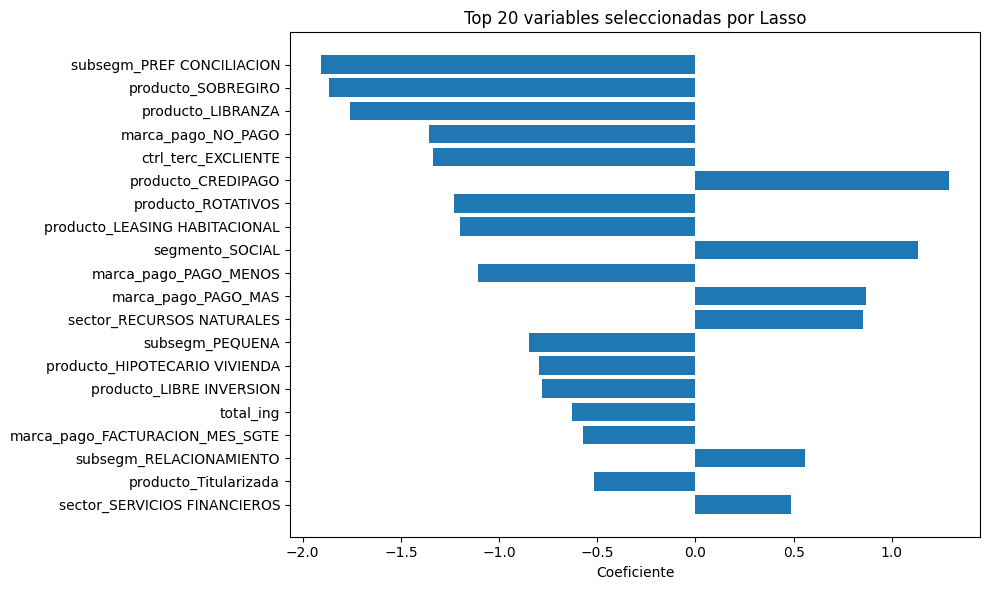

In [18]:
# ==========================================
# 5. Exportar ranking de variables Lasso
# ==========================================

coefficients = lasso_model.coef_[0]
coef_df = pd.DataFrame({
    'feature': X_nocolineal.columns,
    'coefficient': coefficients
})
coef_df = coef_df[coef_df['coefficient'] != 0]
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

# Graficar top 20
plt.figure(figsize=(10, 6))
plt.barh(coef_df['feature'].iloc[:20], coef_df['coefficient'].iloc[:20])
plt.xlabel('Coeficiente')
plt.title('Top 20 variables seleccionadas por Lasso')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Exportar ranking
os.makedirs('../data/procesed', exist_ok=True)
coef_df[['feature']].to_csv('../data/procesed/features.csv', index=False)

In [19]:
# ===================================
# 6. Exportar DataFrame final limpio
# ===================================

# Crear DataFrame final
X_nocolineal_df = X_nocolineal.copy()
df_final = pd.concat([
    df[['id']],
    y,
    X_nocolineal_df[selected_features]
], axis=1)

df_final.to_csv('../data/procesed/df_procesed.csv', index=False)
print(f"✅ DataFrame final exportado. Shape: {df_final.shape}")

✅ DataFrame final exportado. Shape: (55780, 115)
